## Exercise 2.2: Multi class classification


The multi-class percpetron can be implemented this way. 
We denote $K$ the number of classes, $N$ the number of (training) examples, $D$ the dimension of the data (after feature augmentation, at least with a "1" as first component).

The **output** of the network *(not equal to the predicted label)*, can be taken as the **softmax** among the $K$ separating hyperplanes (each hyperplane $\vec{w}_k$ separates class $k$ from the others).
$$ y_k^{(n)} = \text{softmax}\big( (\vec{w}_{k} \cdot \vec{x}^{(n)})_{k=1...K} \big) = \frac{ \exp(  \vec{w}_k\cdot\vec{x}^{(n)}   )}{\sum_\ell \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})}$$ 


This output can be **interpreted as the probability** that example $x^{(n)}$ belongs to the class $k$, according the classifier's current parameters
Indeed, one can easily check that for any $\vec{x}$, the sum of probabilities is indeed one : $\sum_k y_k = 1$.
The **total output of the network** is a vector $\vec{y}^{(n)} = \begin{pmatrix}y_1^{(n)} \\ y_2^{(n)} \\ .. \\ y_K^{(n)} \end{pmatrix}$ (for the sample number $n$).

The **true labels (ground truth)** of example $\vec{x}^{(n)}$ is then encoded as a one-hot vector, so that if the example is of the second class, it may be written: $\vec{t}^{n} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ .. \\ 0 \end{pmatrix}$. (where $\vec{t}^{(n)}$ or $\vec{t}^{n}$ is for **T**ruth and is shorter to write than $\vec{y}^{GT,(n)}$). More generally, the components $t_{n,k}$ of vector $\vec{t}_n$ may be written using the Kronecker's delta: $t_{n,k} = \delta(k, k_{true}^n)$, where $k_{true}^n$ is the true class of example number $n$. 



From now on, **we drop the superscrip $a^{(n)}$ and instead write $a_n$ or just $a$**, when it's clear enough that the quantity $a$ relates to a single example, of generic index $n$. This helps to lighten the notations.

The Loss function that we should use is called the **cross-entropy loss function**, and is:

$$J = \frac1N \sum_n^N H(\vec{t}_{n}, \vec{y}_{n})$$

where the cross-entropy is a non-symmetric function: $$H(\vec{t}_{n}, \vec{y}_{n}) = -\sum_k^K t_{n,k} \log (y_{n,k})$$ 

Make sure you undersand all of the above. Write down the Loss function for the multi-class perceptron. 
### Part 2.1
- What are the parameters of the model ? **How many real numbers is that ?** Count them in terms of $N,K,D, etc$. 
- (3-4 points) **Derive the update steps for the gradient**. (you can get inspiration from TD4.1)
- Some Hints:
    - It is recommended to compute the quantity $\nabla_{w_\ell} y_k$ ($\ell\neq k$) and the quantity $\nabla_{w_k} y_k$. Try to express these simply, by recognizing $y$ when it appears. First treat the two cases separately, then try to unite the two cases in a single mathematical form, using Kronecker's delta : $\delta(i,j)= \{1$ if $i=j$, else $0\}$.
    - When there is a sum $\sum_\ell f(w_\ell)$ and you derive with respect to $w_k$, the output only depends on the term $f(w_k)$ 
    - In the sum above, $\sum_\ell f(w_\ell)$ the index $\ell$ is a "mute" index: you can use any letter for it. Be careful not to use a letter that already exists outside the sum ($\ell$ is like a local variable, don't use the same name for a "global variable" from outside the function !)
    - For any functions $u,v$ that admit derivatives, $\partial_x \frac{u(x)}{v(x)} = \frac{u'(x)v(x)-u(x)v'(x)}{(v(x))^2}$. It extends to $\nabla_x$ without problem.
    - $\nabla_x \exp(u(x)) =  \exp(u(x)) \nabla_x u(x)$.
    - $\frac{a}{1+a} = 1- \frac{1}{1+a}$
    - $\partial_x \log(u(x)) = \frac{u'(x)}{u(x)}$ 
    - If you are too much blocked, you can ask me (via discord, in Private Message) for the solution of $\nabla_{w_k} y_k$ and/or the solution for $\nabla_{w_\ell} y_k$ ($\ell\neq k$).
    - In the end, the update step for the parameters that you should find is : $$ \vec{w}_\ell \mapsto \vec{w}_\ell + \eta \frac1N \sum_n^N \vec{x}_n (\delta_{\ell, k_{true}^n}- y_{\ell,n})$$
    - If you cannot find the equation above, you can just skip this question and use it to make your program.
    


In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split


import numpy as np
data = np.load('/home/flandes/data/fashion-mnist-reshaped.npz')
X = data['train_images']
y = data['train_labels']
X_test = data['test_images']
y_test = data['test_labels']

## we will do the train/val split inside the fit function
# X_train, X_vald, y_train, y_vald = train_test_split(X, y, test_size=0.9, random_state=42)
X_train, y_train = X,y


In [3]:
# plot the first 10 images from the training set and their labels
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()


In [4]:
# Number of parameters : D * K

 In the end, the update step for the parameters that you should find is : $$ \vec{w}_\ell \mapsto \vec{w}_\ell - \eta \frac1N \sum_n^N \vec{x}_n (y_{\ell,n} - \delta_{\ell, k_{true}^n})$$

In [21]:
class MultiClassClassification:

    ## Note: most of the functions defined above should be members of the class instead

    def __init__(self, ETA=0.01, ITERMAX=100):
        self.ETA = ETA
        self.ITERMAX = ITERMAX

    def oneHotEncoding(Y, K):
        N = Y.shape[0]
        ohe = np.zeros((N, K))        
        for n in range(N):
            ohe[n, Y[n]] = 1 
        return ohe
    
    ## other version of the same thing
    def one_hot_encoding(y, K):
        # y is a vector of size N x 1 with values in [0,...,K-1]
        # K is the number of classes
        # returns a matrix of size N x K
        return np.array([[(i==j)*1 for j in range(K)] for i in y])
    
        
    def model(X,W):   ## what we usually denote f_\theta
        # X is a matrix of size N x D
        # W is a matrix of size D x K
        z = X @ W
        return z

    def softmax(z):
        assert(len(z.shape)==2)
        # subtracting the max for numerical stability
        z -= np.max(z, axis=1, keepdims=True)  ## take the max along index k
        exp_z = np.exp(z)
        # returns a matrix of size N x K
        soft = exp_z / np.sum(exp_z, axis=1, keepdims=True) ## sum over k's
        return soft 

    ## we could/should symmetrize the binary cross-entropy, in general
    def cross_entropy_loss(X, Yohe, W):
        # X is a matrix of size N x D
        # W is a matrix of size D x K
        # Y is a matrix of size N x K
        N = X.shape[0]
        Y_hat = softmax(model(X,W))
        # returns a scalar
        loss = -np.sum(Yohe * np.log(Y_hat + 1e-8)) / N 
        return loss ## we could/should symmetrize the binary cross-entropy, in general

    def fit(self, Xinput, yinput):

        ## these 2 functions are only needed within the fit function:
        def grad_wrt_W(softmax, X, Yohe, W):
            # X is a matrix of size N x D
            # Y_hat is a matrix of size N x K
            # Yohe is a matrix of size N x K
            N = X.shape[0]
            Y_hat = softmax(model(X,W))
            # returns a matrix of size D x K
            gradient = 1/N * (X.T @ (Y_hat - Yohe)) 
            return gradient ## we could/should symmetrize the binary cross-entropy, in general

        def weight_initialization(D, K):
            # D is the number of features
            # K is the number of classes
            # returns a matrix of size D x K
            return np.random.uniform(-1/D, 1/D, (D, K))        

        self.K = len(np.unique(yinput))
        self.N = Xinput.shape[0]
        self.D = Xinput.shape[1]
        
        #validation set size:
        val_set_size = 0.5
        X, X_vald, y, y_vald = train_test_split(Xinput, yinput, test_size=val_set_size, random_state=42)
        
        # y is/will be a vector of size N x 1
        ## we one-hot-encode it:
        Y = one_hot_encoding(y, self.K)        
        Yohe = oneHotEncoding(y, self.K)      
        Yohe_vald = oneHotEncoding(y_vald, self.K)   

#         ## TODO:
#         the trick of the ones !!
        
        self.W = weight_initialization(self.D, self.K)
        self.train_loss = np.zeros(self.ITERMAX)
        self.val_loss   = np.zeros(self.ITERMAX)
        
        for epoch in range(self.ITERMAX):
            self.train_loss[epoch] = cross_entropy_loss(X,      Yohe,      self.W)
            self.val_loss[epoch]   = cross_entropy_loss(X_vald, Yohe_vald, self.W)
            grad_W = grad_wrt_W(softmax, X, Yohe, self.W)
            self.W -= self.ETA * grad_W
        ## return ## we do not need to return anything
            
    def predict(self, X):
        Y_hat = softmax(model(X, self.W))
        return np.argmax(Y_hat, axis=1)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    

    

### Part 2.2
- (3 points) **Think up of all the functions you need to write**, and **put them in a class** (you can get inspiration from the correction of TP3.2) - first write a class skeleton, and **only then, write the methods** inside
- Hints:
    - there may be numerical errors (NaNs) because $\exp(..)$ is too large. You can ease this by noticing the following: for any positive constant $C$, we have $$\frac{ \exp( a_k  )}{\sum_\ell \exp (a_\ell) }  = \frac{C \exp( a_k  )}{C \sum_\ell \exp (a_\ell) }= \frac{\exp( a_k +\log C )}{\sum_\ell \exp (a_\ell +\log C) }$$
    - with this trick, when your arguments in the softmax are too large, you can simply subtract a big constant $\log C$ from its argument, and this will reduce the chances of numerical error, without changing the result. It's a good idea to change the $w $'s with this kind of trick.
    - it's a good idea to define the target labels (ground truth) data in one-hot vectors (as said above), compute them once and for all, and then you never have to compute them again. In practice, you may notice that for an example with label $k_{true}$, then the genreic component number of $k$ of the vector $\vec{t}$ reads: $t_{k} = \delta_{k, k_{true}}$
    - the initial $w$ should be random (not all zeros), preferably, but not too big. A good idea is to have their dispersion be of order $1/D$ at most.
    
For this question, the main goal is to make a theoretically-working, rather clean code, using numpy array-operations (`np.dot`) and not loops, as much as possible. If you manage to do that, you will most likely have a working code (and fast code!)
- (1 point) Test your algorithm on Fashion-MNIST: make a train / validation / test split , fit the model, compute the cross-val error, and the test error. Don't waste time on optimizing hyper-parameters (just take an $\eta$ small enough that you kind of converge. The goal is really to prove that your algorithm does not always crash :)

In [22]:
## command line:
## wget "https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/fashion-mnist-reshaped.npz?ref_type=heads&inline=false"
    
    

## NOTE: to save time, we first train only on 2000 points

In [23]:
clf = MultiClassClassification(ETA=0.00003, ITERMAX=500)
clf.fit(X[:2000], y[:2000])

In [24]:
plt.plot(clf.train_loss, label = "train loss")
plt.plot(clf.val_loss, label = "validation loss")
plt.legend()

In [25]:
clf.train_loss[-1]

1.5854865350727865

In [26]:
## better than this: perform Cross-Validation measure on the train set first
print(f'Train accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Train accuracy: 0.776
Test accuracy: 0.764


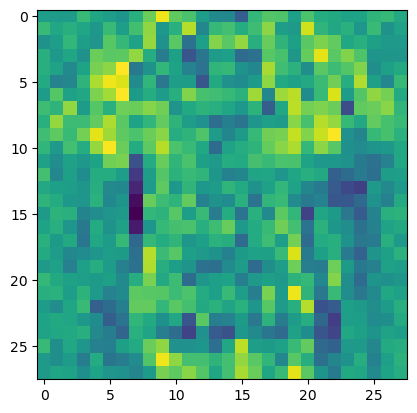

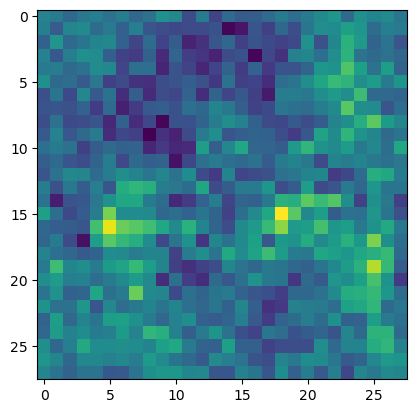

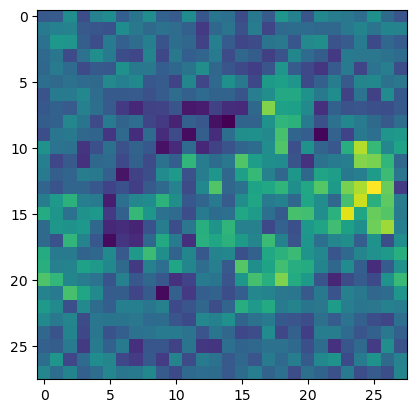

In [27]:
for k in range(10):
    plt.figure()
    plt.imshow(clf.W[:,k].reshape(28,28))
    plt.savefig("W[%i].png"%(k))

## NOTE: ow we train on all data

In [28]:
X.shape

(60000, 784)

In [29]:
clf = MultiClassClassification(ETA=0.0003, ITERMAX=200)
clf.fit(X[:], y[:])

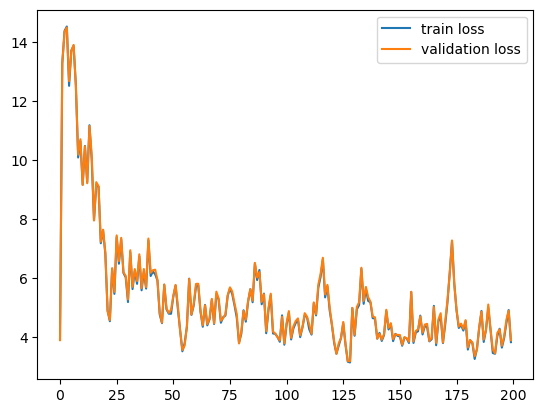

In [30]:
plt.plot(clf.train_loss, label = "train loss")
plt.plot(clf.val_loss, label = "validation loss")
plt.legend()

In [31]:
## better than this: perform Cross-Validation measure on the train set first
print(f'Train accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Train accuracy: 0.760
Test accuracy: 0.747


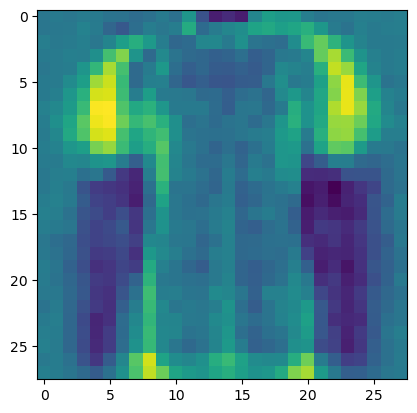

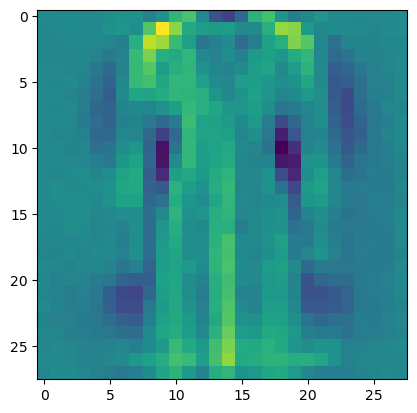

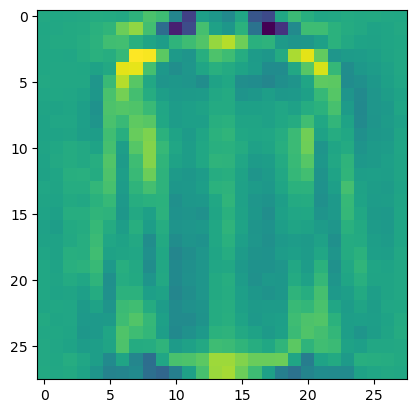

In [32]:
for k in range(10):
    plt.figure()
    plt.imshow(clf.W[:,k].reshape(28,28))
    plt.savefig("W[%i].png"%(k))